In [1]:
# import the relevant libraries
import numpy as np
import cv2 # openCV

In [2]:
# let us take a look at the backed-up model configuration files
%ls /content/drive/MyDrive/my_model/

backup/                  face_mask.data     validation_data.txt
chart_yolov4.png         Makefile           yolov4.cfg
face_mask_classes.names  training_data.txt  yolov4.weights


In [3]:
# let us take a look at the backed-up model training files
%ls /content/drive/MyDrive/my_model/backup/

yolov4_1000.weights  yolov4_best.weights   yolov4_last.weights
yolov4_2000.weights  yolov4_final.weights


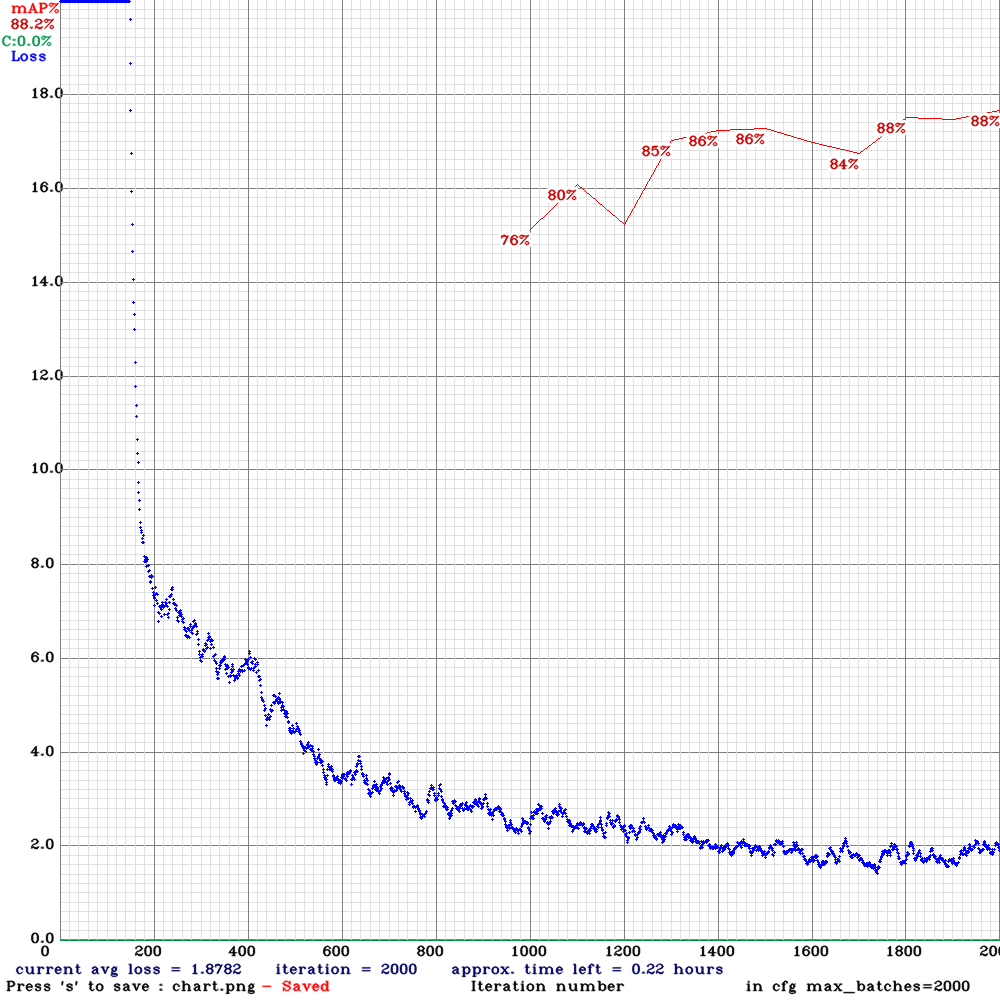

In [4]:
# import the cv2_imshow as a replacement of cv2.imshow to prevent errors
# let us analyse the training process
from google.colab.patches import cv2_imshow
chart = cv2.imread("/content/drive/MyDrive/my_model/chart_yolov4.png")
cv2_imshow(chart)


In [5]:
# first create a directory to store the model
%mkdir model

In [6]:
# enter the directory and download the necessary files
%cd model
%cp /content/drive/MyDrive/my_model/backup/yolov4_best.weights .
%cp /content/drive/MyDrive/my_model/yolov4.cfg .
%cp /content/drive/MyDrive/my_model/face_mask_classes.names .
%cd ..

/content/model
/content


In [7]:
# create a directory for test data
%mkdir test_data

/content/test_data
/content


In [8]:
# access the test data files from GitHub link:
!wget https://github.com/georgiosouzounis/object-detection-yolov4/raw/main/data/custom/test_gko_rs.jpg
!wget https://raw.githubusercontent.com/georgiosouzounis/object-detection-yolov4/main/data/custom/test_gko_rs_ground_truth.txt

--2023-09-11 05:16:55--  https://github.com/georgiosouzounis/object-detection-yolov4/raw/main/data/custom/test_gko_rs.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/georgiosouzounis/object-detection-yolov4/main/data/custom/test_gko_rs.jpg [following]
--2023-09-11 05:16:55--  https://raw.githubusercontent.com/georgiosouzounis/object-detection-yolov4/main/data/custom/test_gko_rs.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159247 (156K) [image/jpeg]
Saving to: ‘test_gko_rs.jpg’

test_gko_rs.jpg     100%[===================>] 155.51K  --.-KB/s    in 0.01s   

2023-09-11 05:16:56 (10

In [26]:
%cd test_data
%mv /content/test_gko_rs.jpg .
%mv /content/test_gko_rs_ground_truth.txt .
%cd ..

/content/test_data
/content


In [28]:
# read file
test_img = cv2.imread('test_data/test_gko_rs.jpg')

# display test image
cv2_imshow(test_img)

AttributeError: ignored

In [11]:
scalefactor = 1.0/255.0
new_size = (416, 416)
blob = cv2.dnn.blobFromImage(test_img, scalefactor, new_size, swapRB=True, crop=False)

In [12]:
# Define the class labels
class_labels_path = "/content/model/face_mask_classes.names"
class_labels = open(class_labels_path).read().strip().split("\n")
class_labels

['no face mask', 'face mask']

In [13]:
# declare repeating bounding box colors for each class
# 1st: create a list colors as an RGB string array
# Example: Red, Green,
class_colors = ["255,0,0","0,255,0"]

In [14]:
# 2nd: split the array on comma-separated strings and for change each string type to integer
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]

In [15]:
# 3d: convert the array or arrays to a numpy array
class_colors = np.array(class_colors)

In [16]:
#Finally, let’s load and run the model using the following commands:
# Load the pre-trained model
yolo_model = cv2.dnn.readNetFromDarknet('model/yolov4.cfg','model/yolov4_best.weights')


In [17]:
# Read the network layers/components
model_layers = yolo_model.getLayerNames()

In [18]:
# Extract the output layers
output_layers = [model_layers[model_layer - 1] for model_layer in yolo_model.getUnconnectedOutLayers()]

In [19]:
# input pre-processed blob into the model
yolo_model.setInput(blob)

In [20]:
# compute the forward pass for the input, storing the results per output layer in a list
obj_detections_in_layers = yolo_model.forward(output_layers)

In [21]:
# verify the number of sets of detections
print("number of sets of detections: " + str(len(obj_detections_in_layers)))

number of sets of detections: 3


predicted object face mask: 99.20%


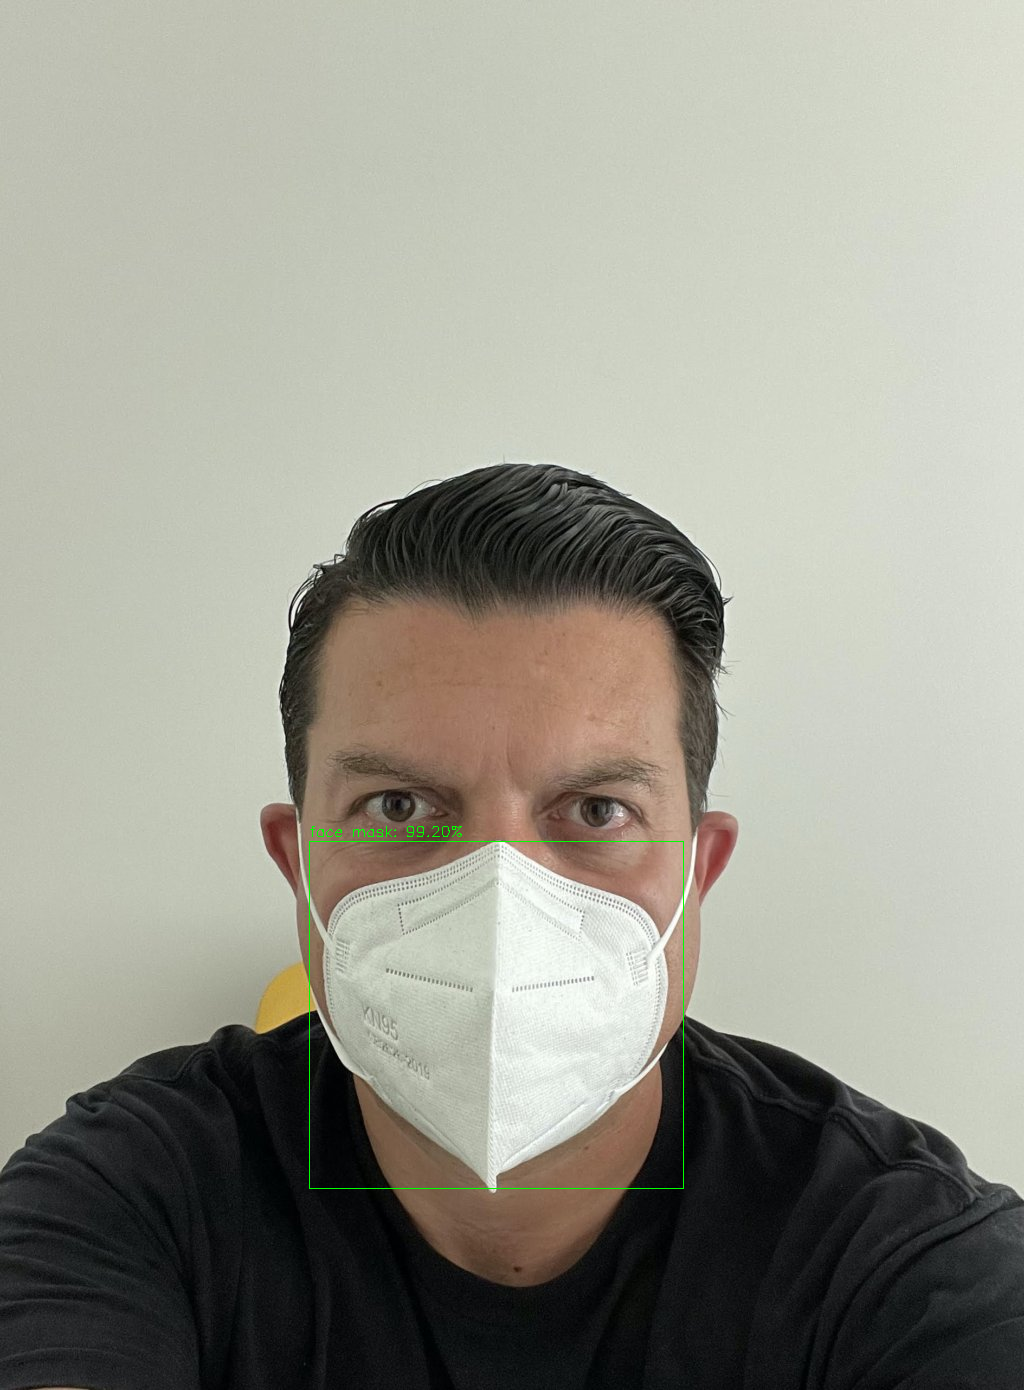

In [22]:
#The objective now is to get each object detection from each output layer and evaluate the algorithm's confidence score against a threshold.
#For high confidence detections, the model will extract the class ID and the bounding box info and apply non-maximum suppression.
#This can be done using the following code:

%cp /content/drive/MyDrive/object_detection_functions.py .

from object_detection_functions import object_detection_analysis_with_nms

score_threshold = 0.5
nms_threshold = 0.4
result, winner_boxes = object_detection_analysis_with_nms(test_img, class_labels, class_colors, obj_detections_in_layers, score_threshold, nms_threshold)

cv2_imshow(result)

In [23]:
#Now, in order to analyse the quality of prediction, you need to compute the IoU, as shown below.
import io

ground_truth_boxes = []

with io.open("test_data/test_gko_rs_ground_truth.txt", mode="r", encoding="utf-8") as f:
  for line in f:
    ground_truth_boxes.append(line.split())

for i in range(0, len(ground_truth_boxes)):
  for j in range(0, len(ground_truth_boxes[i])):
    ground_truth_boxes[i][j] = int(ground_truth_boxes[i][j])

iou = 0.9167
0.9167222788100172


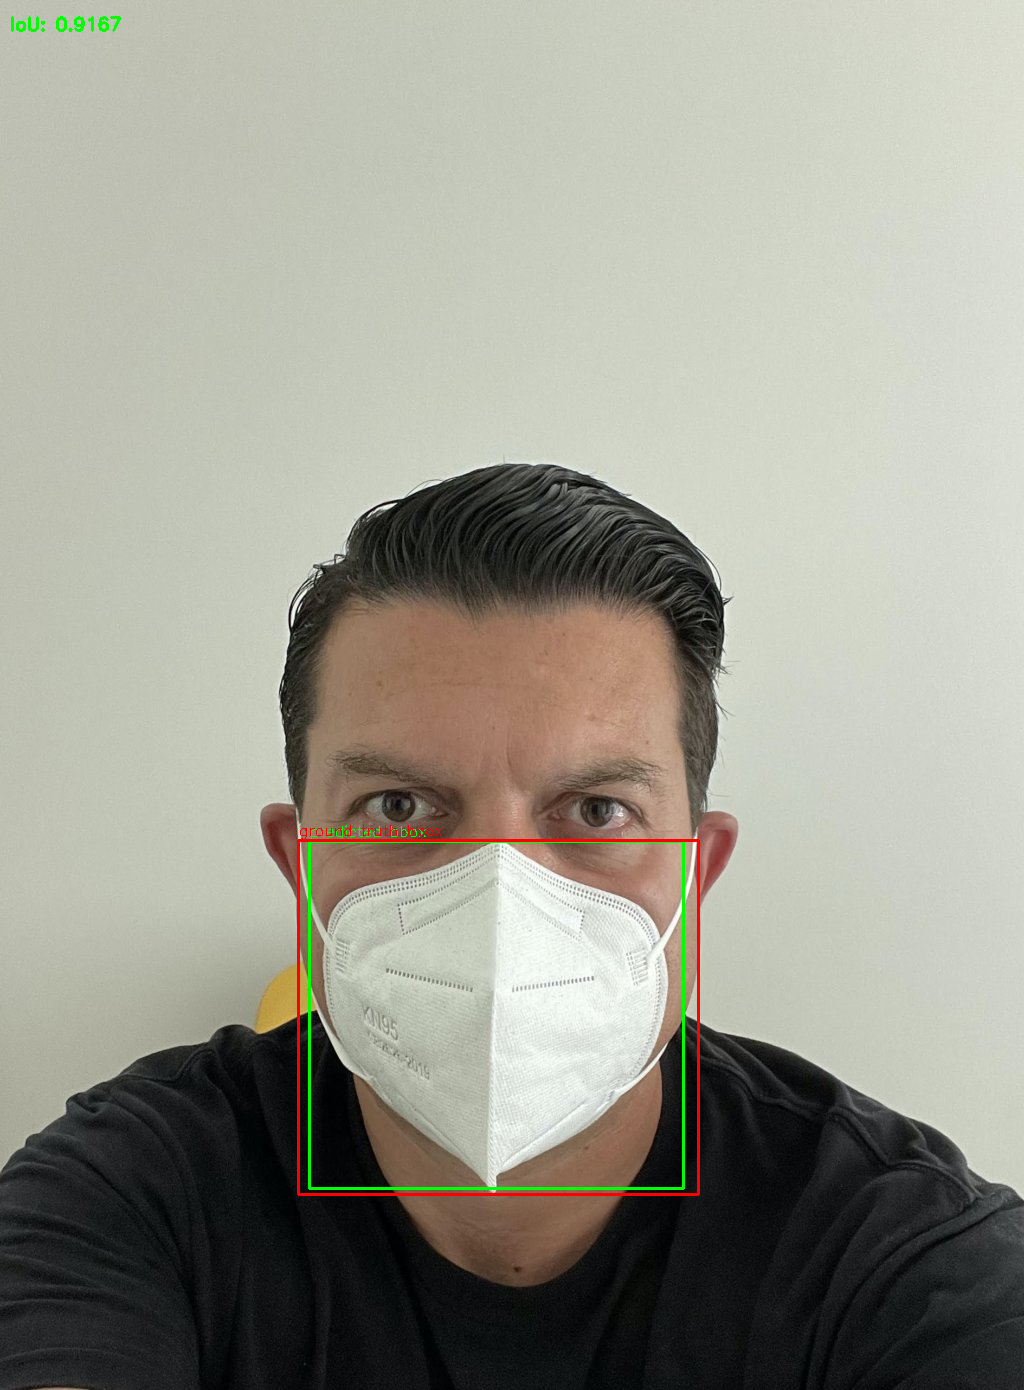

In [25]:
#Finally, let’s visualise the predicted bounding box against the ground truth using the following commands:
from object_detection_functions import object_detection_iou

# create a copy of the test image
iou_image = test_img.copy()

# print the ground truth and detection bounding boxes, and the IoU value
iou_image, iou_value = object_detection_iou(test_img, winner_boxes[0], ground_truth_boxes[0])
print(iou_value)
cv2_imshow(iou_image)